# Sentence Embedding - Présentation générale

* Ce notebook présente différentes techniques de "Sentence Embeddings", permettant de générer des features à partir de phrases (ici des tweets)
* L'objectif est de pouvoir séparer les sentiments des tweets de façon automatique, via un T-SNE, qui permet une réduction des features en 2 dimensions
* C'est un notebook d'exemples afin de mieux comprendre la mise en oeuvre des techniques. Il n'est pas optimisé et doit être adapté à un nouveau contexte, en particulier sur les points suivants :
    * Le nettoyage des textes
    * les modèles BERT (model_type) idéalement pré-entraînés sur des données similaires au contexte (ici le modèle 'cardiffnlp/twitter-roberta-base-sentiment' surperforme le modèle de base car il a été pré-entraîné sur des tweets)
    * La taille des vecteurs (max_length)
    * Le batch_size
    * La perplexité du Tsne (perplexity à 30 par défaut)

# Préparation initiale dataset

## Récupération du dataset et filtres de données

In [1]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [3]:
number_cat = 10
tree_level = 1

In [4]:
path_csv = './data/Flipkart/flipkart_com-ecommerce_sample_1050.csv'

In [5]:
data = pd.read_csv(path_csv)

In [6]:
data['product_category_list'] = data['product_category_tree'].apply(lambda e : e[2:-2]).str.split(' >> ')
data['product_category_last'] = data['product_category_list'].apply(lambda e : e[-1])

In [7]:
data = data[['product_name', 'product_category_list', 'description']].copy()
data.columns = ['name', 'category_list', 'description']

In [8]:
data['category'] = data['category_list'].apply(lambda l : l[tree_level] if tree_level<len(l) else l[-1])

In [9]:
data

,name,category_list,description,category
0,Elegance Polyester Multicolor Abstract Eyelet ...,"[Home Furnishing, Curtains & Accessories, Curt...",Key Features of Elegance Polyester Multicolor ...,Curtains & Accessories
1,Sathiyas Cotton Bath Towel,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...",Specifications of Sathiyas Cotton Bath Towel (...,Baby Bath & Skin
2,Eurospa Cotton Terry Face Towel Set,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...",Key Features of Eurospa Cotton Terry Face Towe...,Baby Bath & Skin
3,SANTOSH ROYAL FASHION Cotton Printed King size...,"[Home Furnishing, Bed Linen, Bedsheets, SANTOS...",Key Features of SANTOSH ROYAL FASHION Cotton P...,Bed Linen
4,Jaipur Print Cotton Floral King sized Double B...,"[Home Furnishing, Bed Linen, Bedsheets, Jaipur...",Key Features of Jaipur Print Cotton Floral Kin...,Bed Linen
...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,"[Baby Care, Baby & Kids Gifts, Stickers, Oren ...",Oren Empower Extra Large Self Adhesive Sticker...,Baby & Kids Gifts
1046,Wallmantra Large Vinyl Sticker Sticker,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",Wallmantra Large Vinyl Sticker Sticker (Pack o...,Baby & Kids Gifts
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[Baby Care, Baby & Kids Gifts, Stickers, Uberl...",Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Baby & Kids Gifts
1048,Wallmantra Medium Vinyl Sticker Sticker,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Baby & Kids Gifts


<Axes: >

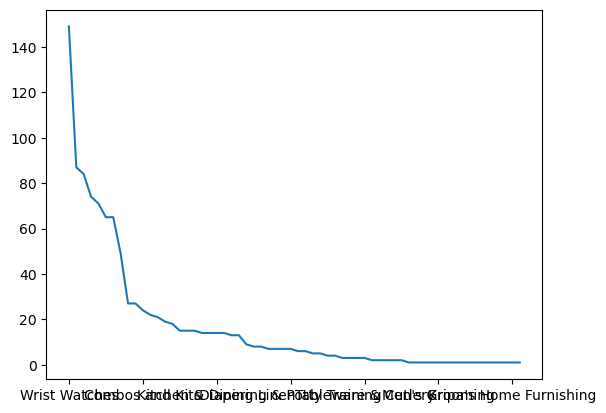

In [10]:
data['category'].value_counts().plot()

In [11]:
len(data['category'].unique())

62

In [12]:
list_cat = list(data['category'].value_counts().index)[:number_cat]
list_cat

['Wrist Watches',
 'Laptop Accessories',
 'Infant Wear',
 'Coffee Mugs',
 'Showpieces',
 'Bed Linen',
 'Fragrances',
 'Network Components',
 'Cookware',
 'Table Decor & Handicrafts']

In [13]:
data = data.loc[data['category'].isin(list_cat)].copy()

In [14]:
data['category_num'] = data['category'].apply(lambda e : list_cat.index(e))

In [15]:
data

,name,category_list,description,category,category_num
3,SANTOSH ROYAL FASHION Cotton Printed King size...,"[Home Furnishing, Bed Linen, Bedsheets, SANTOS...",Key Features of SANTOSH ROYAL FASHION Cotton P...,Bed Linen,5
4,Jaipur Print Cotton Floral King sized Double B...,"[Home Furnishing, Bed Linen, Bedsheets, Jaipur...",Key Features of Jaipur Print Cotton Floral Kin...,Bed Linen,5
5,Maserati Time R8851116001 Analog Watch - For ...,"[Watches, Wrist Watches, Maserati Time Wrist W...",Maserati Time R8851116001 Analog Watch - For ...,Wrist Watches,0
6,"Camerii WM64 Elegance Analog Watch - For Men,...","[Watches, Wrist Watches, Camerii Wrist Watches]","Camerii WM64 Elegance Analog Watch - For Men,...",Wrist Watches,0
7,T STAR UFT-TSW-005-BK-BR Analog Watch - For Boys,"[Watches, Wrist Watches, T STAR Wrist Watches]",T STAR UFT-TSW-005-BK-BR Analog Watch - For B...,Wrist Watches,0
...,...,...,...,...,...
1032,PRINT SHAPES mary and max cartoon Laptop Skin ...,"[Computers, Laptop Accessories, Computer Acces...",Key Features of PRINT SHAPES mary and max cart...,Laptop Accessories,1
1034,PRINT SHAPES Peacock Feather Laptop Skin with ...,"[Computers, Laptop Accessories, Computer Acces...",Key Features of PRINT SHAPES Peacock Feather L...,Laptop Accessories,1
1035,PRINT SHAPES despicable me 2 looking upwards L...,"[Computers, Laptop Accessories, Computer Acces...",Key Features of PRINT SHAPES despicable me 2 l...,Laptop Accessories,1
1036,PRINT SHAPES Red bull Laptop Skin with Mouse p...,"[Computers, Laptop Accessories, Computer Acces...",Key Features of PRINT SHAPES Red bull Laptop S...,Laptop Accessories,1


## Nettoyage du texte

In [16]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

In [17]:
nlp = spacy.load("en_core_web_sm")

def get_tokens(text):
    doc = nlp(text)

    filtered_tokens = []

    for token in doc:
        if not token.is_punct and not token.is_space and not token.is_digit:
            normalized_token = token.lemma_.lower()
            if normalized_token not in STOP_WORDS:
                filtered_tokens.append(normalized_token)
    return filtered_tokens

In [18]:
get_tokens("I'm don't 3 black cat sitting on the two mat.")

['black', 'cat', 'sit', 'mat']

In [19]:
data_T = data.copy()

In [20]:
data_T['description_words'] = data_T['description'].apply(lambda t : get_tokens(t))
data_T['description_text'] = data_T['description_words'].str.join(' ')

In [21]:
data_T

,name,category_list,description,category,category_num,description_words,description_text
3,SANTOSH ROYAL FASHION Cotton Printed King size...,"[Home Furnishing, Bed Linen, Bedsheets, SANTOS...",Key Features of SANTOSH ROYAL FASHION Cotton P...,Bed Linen,5,"[key, features, santosh, royal, fashion, cotto...",key features santosh royal fashion cotton prin...
4,Jaipur Print Cotton Floral King sized Double B...,"[Home Furnishing, Bed Linen, Bedsheets, Jaipur...",Key Features of Jaipur Print Cotton Floral Kin...,Bed Linen,5,"[key, features, jaipur, print, cotton, floral,...",key features jaipur print cotton floral king s...
5,Maserati Time R8851116001 Analog Watch - For ...,"[Watches, Wrist Watches, Maserati Time Wrist W...",Maserati Time R8851116001 Analog Watch - For ...,Wrist Watches,0,"[maserati, time, r8851116001, analog, watch, b...",maserati time r8851116001 analog watch boys bu...
6,"Camerii WM64 Elegance Analog Watch - For Men,...","[Watches, Wrist Watches, Camerii Wrist Watches]","Camerii WM64 Elegance Analog Watch - For Men,...",Wrist Watches,0,"[camerii, wm64, elegance, analog, watch, man, ...",camerii wm64 elegance analog watch man boys bu...
7,T STAR UFT-TSW-005-BK-BR Analog Watch - For Boys,"[Watches, Wrist Watches, T STAR Wrist Watches]",T STAR UFT-TSW-005-BK-BR Analog Watch - For B...,Wrist Watches,0,"[t, star, uft, tsw-005, bk, br, analog, watch,...",t star uft tsw-005 bk br analog watch boys pri...
...,...,...,...,...,...,...,...
1032,PRINT SHAPES mary and max cartoon Laptop Skin ...,"[Computers, Laptop Accessories, Computer Acces...",Key Features of PRINT SHAPES mary and max cart...,Laptop Accessories,1,"[key, features, print, shapes, mary, max, cart...",key features print shapes mary max cartoon lap...
1034,PRINT SHAPES Peacock Feather Laptop Skin with ...,"[Computers, Laptop Accessories, Computer Acces...",Key Features of PRINT SHAPES Peacock Feather L...,Laptop Accessories,1,"[key, features, print, shapes, peacock, feathe...",key features print shapes peacock feather lapt...
1035,PRINT SHAPES despicable me 2 looking upwards L...,"[Computers, Laptop Accessories, Computer Acces...",Key Features of PRINT SHAPES despicable me 2 l...,Laptop Accessories,1,"[key, features, print, shapes, despicable, loo...",key features print shapes despicable look upwa...
1036,PRINT SHAPES Red bull Laptop Skin with Mouse p...,"[Computers, Laptop Accessories, Computer Acces...",Key Features of PRINT SHAPES Red bull Laptop S...,Laptop Accessories,1,"[key, features, print, shapes, red, bull, lapt...",key features print shapes red bull laptop skin...


In [22]:
data_T.to_csv("./data/data_text.csv")

# Préparation commune des traitements

In [23]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

#logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

## Lecture dataset

In [24]:
data_T =  pd.read_csv("./data/data_text.csv")
print(data_T.shape)

(698, 8)


In [25]:
l_cat = data_T['category'].unique()
y_cat_num = data_T['category_num']

## Fonctions communes

In [26]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100)
    cls.fit(X_tsne)
    
    len_min = min(len(y_cat_num), len(cls.labels_))
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num[:len_min], cls.labels_[:len_min]),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num[:len(X_tsne)], cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=list(l_cat), loc="best", title="Categorie")
    plt.title('Représentation des descriptions par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels[:len(X_tsne)], cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des descriptions par clusters')
    
    plt.show()
    print("ARI : ", ARI)


In [27]:
def get_max_coord(data):
    max_value = data.values.max()
    return list(zip(*np.where(data.values == max_value)))[0]

In [28]:
def compare_clustering(original, predict, return_cat=False):
    original = list(original)
    data_show = pd.DataFrame(original, columns=['cat'])
    data_show['pred'] = predict
    data_show = pd.get_dummies(data_show, columns=['pred'])
    data_show = data_show.groupby('cat').sum(numeric_only=True)
    

    cat_restante = list(data_show.index)
    col_restante = list(data_show.columns)
    cat_final = []
    col_final = []
    for i in range(len(data_show)):
        i_cat, i_col = get_max_coord(data_show.loc[cat_restante, col_restante])
        n_col, n_cat = col_restante[i_col], cat_restante[i_cat]

        col_final.append(n_col)
        col_restante.remove(n_col)
        cat_final.append(n_cat)
        cat_restante.remove(n_cat)
    
    if return_cat:
        return cat_final, col_final

    print('ARI : ', metrics.adjusted_rand_score(original, predict))
    
    return data_show.loc[cat_final, col_final].style.background_gradient(cmap="YlGnBu", axis=0)

# Bag of word - Tf-idf

## Préparation sentences

In [29]:
feat = 'description_text'

In [30]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(max_df=0.95, min_df=1)
ctf = TfidfVectorizer(max_df=0.95, min_df=1)

cv_fit = cvect.fit(data_T[feat])
ctf_fit = ctf.fit(data_T[feat])

cv_transform = cvect.transform(data_T[feat])  
ctf_transform = ctf.transform(data_T[feat])  

## Exécution des modèles

In [31]:
print("CountVectorizer : ")
print("-----------------")
ARI_cv, X_tsne_cv, labels_cv = ARI_fct(cv_transform)

print()
print("Tf-idf : ")
print("--------")
ARI_ctf, X_tsne_ctf, labels_ctf = ARI_fct(ctf_transform)

CountVectorizer : 
-----------------
ARI :  0.5912 time :  35.0

Tf-idf : 
--------
ARI :  0.7354 time :  23.0


## Graphiques

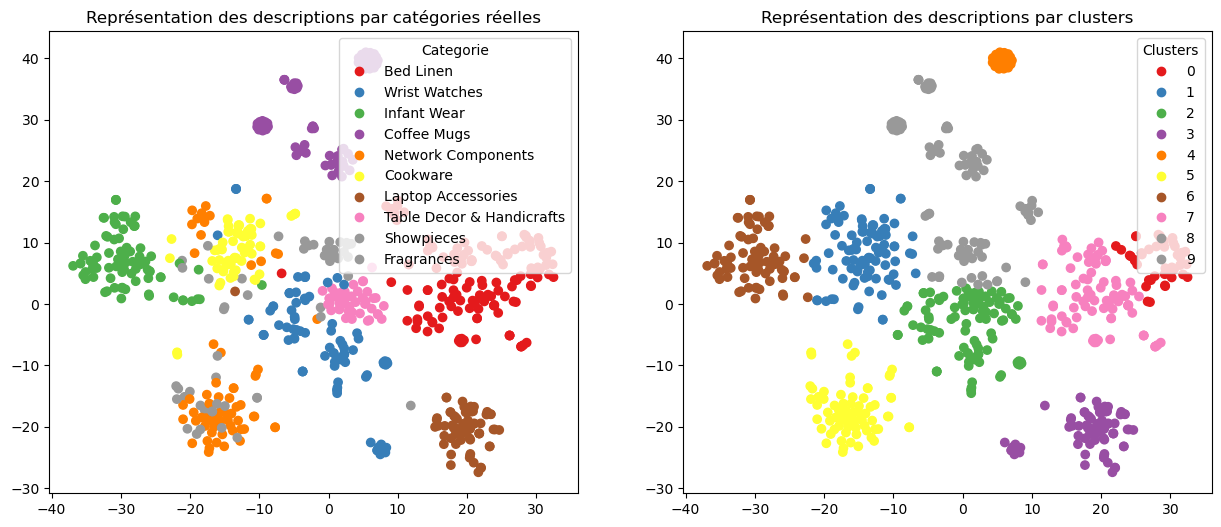

ARI :  0.5912


In [32]:
TSNE_visu_fct(X_tsne_cv, y_cat_num, labels_cv, ARI_cv)

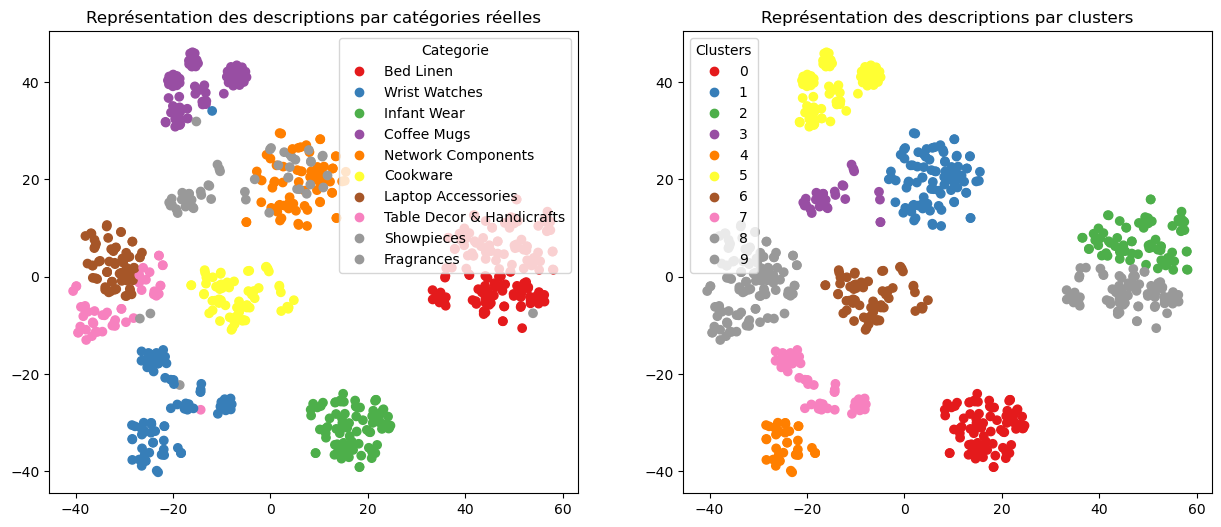

ARI :  0.7354


In [33]:
TSNE_visu_fct(X_tsne_ctf, y_cat_num, labels_ctf, ARI_ctf)

In [34]:
list_cat = list(data_T['category'])

In [35]:
compare_clustering(list_cat, labels_ctf)

ARI :  0.7354195309626516


,pred_0,pred_2,pred_5,pred_1,pred_6,pred_8,pred_7,pred_3,pred_4,pred_9
cat,,,,,,,,,,
Infant Wear,84,0,0,0,0,0,0,0,0,0
Wrist Watches,0,75,0,0,0,0,0,0,0,74
Coffee Mugs,0,0,74,0,0,0,0,0,0,0
Showpieces,0,0,0,69,0,0,0,2,0,0
Bed Linen,0,0,0,0,65,0,0,0,0,0
Fragrances,0,0,0,0,0,65,0,0,0,0
Laptop Accessories,0,0,1,0,0,0,48,0,38,0
Cookware,0,0,0,1,0,0,1,24,0,1
Network Components,0,0,0,0,0,48,1,0,0,0


In [36]:
compare_clustering(y_cat_num, labels_ctf)

ARI :  0.7354195309626516


,pred_0,pred_2,pred_5,pred_1,pred_6,pred_8,pred_7,pred_3,pred_4,pred_9
cat,,,,,,,,,,
2,84,0,0,0,0,0,0,0,0,0
0,0,75,0,0,0,0,0,0,0,74
3,0,0,74,0,0,0,0,0,0,0
4,0,0,0,69,0,0,0,2,0,0
5,0,0,0,0,65,0,0,0,0,0
6,0,0,0,0,0,65,0,0,0,0
1,0,0,1,0,0,0,48,0,38,0
8,0,0,0,1,0,0,1,24,0,1
7,0,0,0,0,0,48,1,0,0,0


# Word2Vec

In [37]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim
import gensim.downloader as api

## Création du modèle Word2Vec

In [38]:
w2v_size=50
w2v_window=5
w2v_min_count=0
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = data_T[feat].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [39]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv

Build & train Word2Vec model ...


In [40]:
#w2v_size=50
#info = api.info()  # show info about available models/datasets
#model_vectors = api.load("glove-wiki-gigaword-50")  # download the model and return as object ready for use

In [41]:
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Vocabulary size: 2711
Word2Vec trained


In [42]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 2712


## Création de la matrice d'embedding

In [43]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (2712, 50)


## Création du modèle d'embedding

In [44]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 50)            135600    
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 135,600
Trainable params: 135,600
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle

In [45]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

22/22 [==============================] - 0s 1ms/step


(698, 50)

In [46]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.4934 time :  21.0


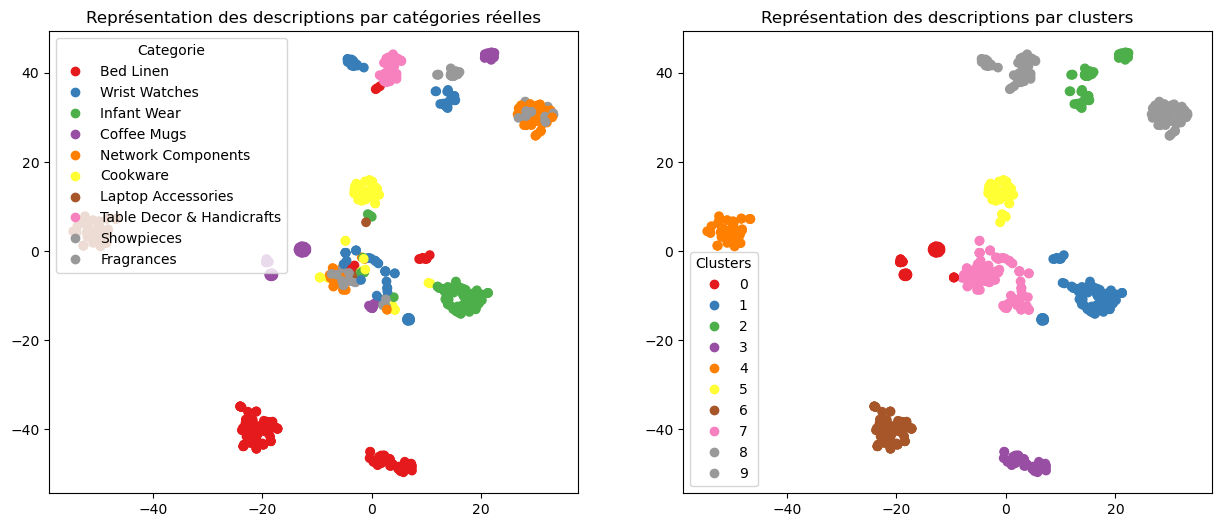

ARI :  0.4934


In [47]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# BERT

In [48]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import BertModel, TFBertModel, TFAutoModel, AutoTokenizer

os.environ["TF_KERAS"]='1'

In [49]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.10.0
2.10.0
Num GPUs Available:  0
False


## Fonctions communes

In [50]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [51]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T[feat].to_list()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [52]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 2s 2s/step
temps traitement :  175.0


In [53]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.5575 time :  24.0


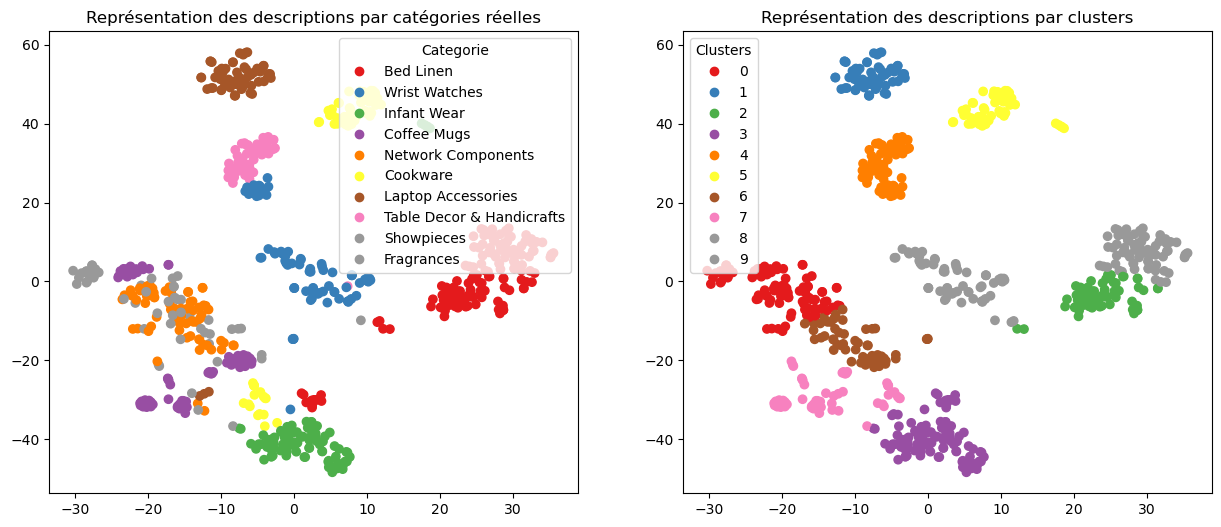

ARI :  0.5575


In [54]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## BERT hub Tensorflow

In [55]:
import tensorflow_hub as hub
import tensorflow_text 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [56]:
sentences = data_T[feat].to_list()

In [57]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  141.0


In [58]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.5634 time :  34.0


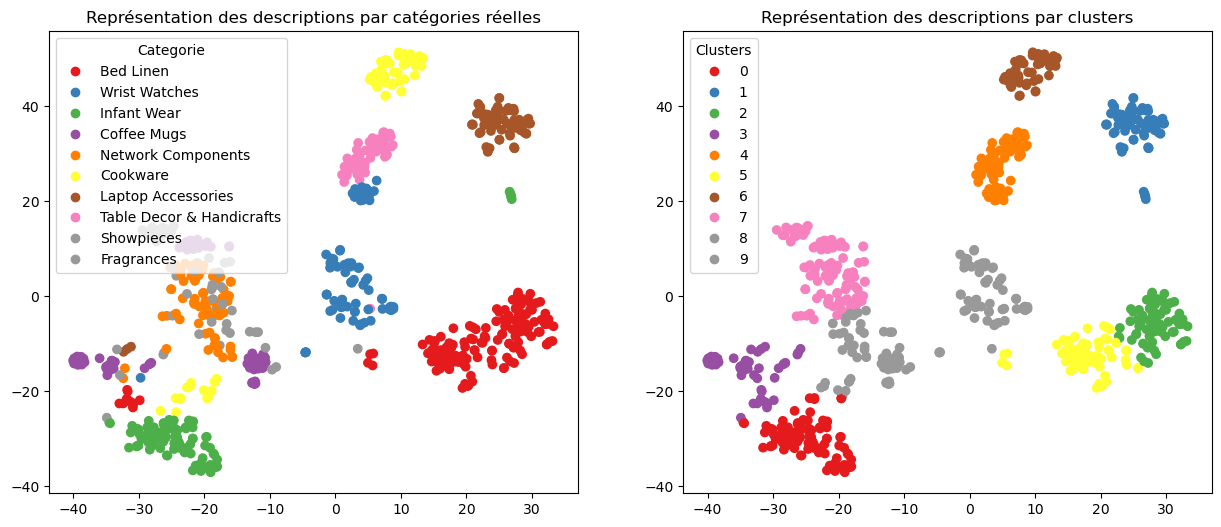

ARI :  0.5634


In [59]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# USE - Universal Sentence Encoder

In [60]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import BertModel, TFBertModel, TFAutoModel, AutoTokenizer

os.environ["TF_KERAS"]='1'

In [61]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.10.0
2.10.0
Num GPUs Available:  0
False


In [62]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [63]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [64]:
batch_size = 10
sentences = data_T[feat].to_list()

In [65]:
features_USE = feature_USE_fct(sentences, batch_size)

In [66]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.6717 time :  24.0


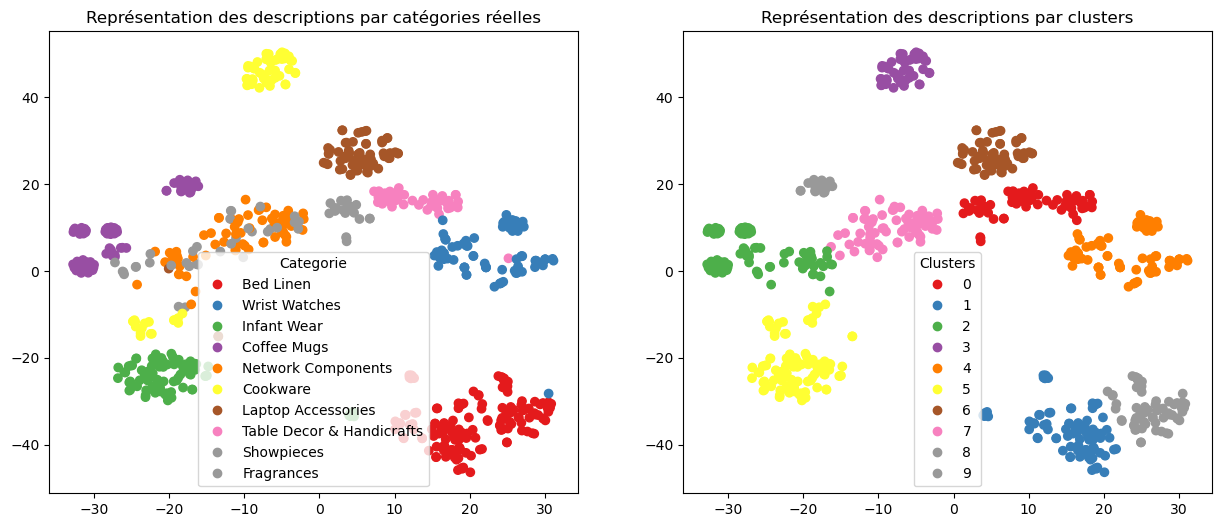

ARI :  0.6717


In [67]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)